## Data preprocessing

In [20]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# === Load and preprocess energy data ===
df = pd.read_csv("mm79158.csv", sep=';', decimal=',')
df['ts'] = pd.to_datetime(df['ts'])
df.set_index('ts', inplace=True)

# Resample to 30-minute intervals and interpolate
df_resampled = df.resample('30min').mean()
df_resampled['vrednost'] = df_resampled['vrednost'].interpolate(method='time')

# Extract time-based features
df_resampled['hour_48'] = df_resampled.index.map(lambda x: (x.hour * 2 + x.minute // 30) + 1)
df_resampled['day_of_week'] = df_resampled.index.dayofweek

# === Load holidays and tag rows ===
holidays = pd.read_csv("slovenian_holidays_2016_2018.csv")
holidays['holiday_date'] = pd.to_datetime(holidays['holiday_date'])
holiday_set = set(holidays['holiday_date'].dt.normalize())
df_resampled['is_holiday'] = df_resampled.index.normalize().isin(holiday_set).astype(int)

# === One-hot encode hour_48, day_of_week, and is_holiday ===
encoder = OneHotEncoder(sparse_output=False)
encoded = encoder.fit_transform(df_resampled[['hour_48', 'day_of_week', 'is_holiday']])
encoded_df = pd.DataFrame(
    encoded,
    columns=encoder.get_feature_names_out(['hour_48', 'day_of_week', 'is_holiday']),
    index=df_resampled.index
)

# === Combine with original value and sort
df_final = pd.concat([df_resampled[['vrednost']], encoded_df], axis=1)
df_final = df_final.sort_index(ascending=True)
df = df_final.copy()


In [2]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def prepare_sequences(df, input_window=48, forecast_horizon=1, val_ratio=0.1, test_ratio=0.1):
    """
    Prepares sliding window sequences for multistep forecasting and applies MinMax scaling to 'vrednost' safely.

    Parameters:
    - df: DataFrame with 'vrednost' as the first column and features after
    - input_window: number of timesteps in the input window
    - forecast_horizon: number of timesteps to predict
    - val_ratio: validation size ratio
    - test_ratio: test size ratio

    Returns:
    - X_train, y_train, X_val, y_val, X_test, y_test, vrednost_scaler
    """
    df = df.copy()  # avoid modifying original

    # === Step 1: Determine sizes
    total_len = len(df) - input_window - forecast_horizon + 1
    val_size = int(total_len * val_ratio)
    test_size = int(total_len * test_ratio)
    train_size = total_len - val_size - test_size

    # Find raw index range for safe fitting
    fit_end_idx = train_size + input_window

    # === Step 2: Fit MinMaxScaler on 'vrednost' using only training range
    # Fit scaler on training data only
    vrednost_scaler = MinMaxScaler()
    df.loc[:df.index[fit_end_idx - 1], 'vrednost'] = vrednost_scaler.fit_transform(
        df.loc[:df.index[fit_end_idx - 1], ['vrednost']]
    ).ravel()

    # Transform validation + test data
    df.loc[df.index[fit_end_idx:], 'vrednost'] = vrednost_scaler.transform(
        df.loc[df.index[fit_end_idx:], ['vrednost']]
    ).ravel()


    # === Step 4: Generate sequences
    values = df.values
    X, y = [], []
    for i in range(total_len):
        X.append(values[i:i + input_window])
        y.append(values[i + input_window:i + input_window + forecast_horizon, 0])  # target = 'vrednost'

    X = np.array(X)
    y = np.array(y)

    if forecast_horizon == 1:
        y = y.reshape(-1, 1)

    # === Step 5: Final chronological split
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

    return X_train, y_train, X_val, y_val, X_test, y_test, vrednost_scaler


## Model creation

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError

def build_cnn_lstm_model(input_shape, output_size=1):
    """
    Builds a CNN-LSTM model with up to 3 MaxPooling layers.
    The number of pooling layers is reduced based on input sequence length
    to avoid collapsing the sequence dimension.

    Parameters:
    - input_shape: (timesteps, features)
    - output_size: number of forecast steps (e.g., 1, 2, 6)

    Returns:
    - compiled Keras model
    """
    time_steps = input_shape[0]
    model = Sequential()

    # Conv 1
    model.add(Conv1D(48, 3, activation='relu', padding='same', input_shape=input_shape))
    if time_steps >= 4:
        model.add(MaxPooling1D(pool_size=2))
        time_steps //= 2

    # Conv 2
    model.add(Conv1D(32, 3, activation='relu', padding='same'))
    if time_steps >= 4:
        model.add(MaxPooling1D(pool_size=2))
        time_steps //= 2

    # Conv 3
    model.add(Conv1D(16, 3, activation='relu', padding='same'))
    if time_steps >= 4:
        model.add(MaxPooling1D(pool_size=2))
        time_steps //= 2

    model.add(Dropout(0.25))

    # LSTM Layers
    model.add(LSTM(20, return_sequences=True))
    model.add(LSTM(20, return_sequences=True))
    model.add(LSTM(20, return_sequences=False))

    model.add(Dropout(0.25))

    # Fully connected
    model.add(Dense(20, activation='relu'))
    model.add(Dense(output_size))  # Output layer (linear)

    model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanAbsoluteError())
    return model


## Training wrapper

In [4]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.metrics import MeanAbsoluteError as MAEMetric
from tensorflow.keras.models import load_model

def train_model(model, X_train, y_train, X_val, y_val, model_path):
    """
    Trains the CNN-LSTM model with ReduceLROnPlateau based on validation MAE.
    Saves the best model based on validation MAE (not loss).
    """
    # Compile with MAE as loss and metric
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=MeanAbsoluteError(),
                  metrics=[MAEMetric(name='mae')])

    # Learning rate scheduler based on val_mae
    lr_schedule = ReduceLROnPlateau(
        monitor='val_loss',
        patience=10,
        factor=0.8,
        min_lr=1e-5,
        verbose=1
    )

    # Save best model based on val_mae
    checkpoint = ModelCheckpoint(
        model_path,
        monitor='val_mae',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )

    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=150,
        batch_size=128,
        callbacks=[lr_schedule, checkpoint],
        verbose=1
    )

    print(history.history.keys())
    return model, history


## Evaluation

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_forecasting_model(model, X_test, y_test, scaler):
    """
    Evaluates a forecasting model and prints MAE, RMSE, MAPE.
    
    Parameters:
    - model: trained Keras model
    - X_test: test input features
    - y_test: true test values (scaled or unscaled)
    - scaler: fitted MinMaxScaler used for target (optional, for inverse scaling)
    
    Returns:
    - Dictionary of MAE, RMSE, MAPE
    """
    # Predict
    y_pred = model.predict(X_test)

    # Inverse scale if scaler is given
    if scaler is not None:
        y_pred = scaler.inverse_transform(y_pred)
        y_test = scaler.inverse_transform(y_test)

    # Evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-8))) * 100

    print(f"📊 Evaluation Metrics:")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")

    return {"mae": mae, "rmse": rmse, "mape": mape}


In [11]:
import matplotlib.pyplot as plt

def plot(model, X_test, y_test, vrednost_scaler):
    # === Run prediction on test set ===
    y_pred_test = model.predict(X_test, verbose=0)  # shape: [samples, horizon]

    # === Only compare the first step of the forecast horizon (t+1) ===
    preds_step1 = y_pred_test[:, 0].reshape(-1, 1)
    true_step1 = y_test[:, 0].reshape(-1, 1)

    # === Inverse transform back to real-world scale ===
    preds_rescaled = vrednost_scaler.inverse_transform(preds_step1)
    true_rescaled = vrednost_scaler.inverse_transform(true_step1)

    # === Plot ===
    import matplotlib.pyplot as plt

    plt.figure(figsize=(30, 7))
    plt.plot(true_rescaled, color='blue', linewidth=0.5, label='True Values')
    plt.plot(preds_rescaled, color='red', linewidth=0.5, label='Predicted Values')
    plt.title("Predicted vs True Values per Sequence")
    plt.xlabel("Forecast Step")
    plt.ylabel("Rescaled Value")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Main loop


🔁 Training with lookback=2, horizon=1
Epoch 1/150


c:\Users\janav\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


276/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0529 - mae: 0.0529
Epoch 1: val_mae improved from inf to 0.01944, saving model to best_model_2_1.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0524 - mae: 0.0524 - val_loss: 0.0194 - val_mae: 0.0194 - learning_rate: 0.0010
Epoch 2/150
270/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0180 - mae: 0.0180
Epoch 2: val_mae improved from 0.01944 to 0.01873, saving model to best_model_2_1.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0180 - mae: 0.0180 - val_loss: 0.0187 - val_mae: 0.0187 - learning_rate: 0.0010
Epoch 3/150
272/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0161 - mae: 0.0161
Epoch 3: val_mae improved from 0.01873 to 0.01817, saving model to best_model_2_1.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0161 - mae: 0.0161 - val_loss: 0.0182 - val_mae: 0.0182 - learning_rate: 0.0010
Epoch 4/150
270/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0153 - mae: 0.0153
Epoch 4: val_mae did not improve from 0.01817
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0153 - mae: 0.0153 - val_loss: 0.0183 - val_mae: 0.0183 - learning_rate: 0.0010
Epoch 5/150
271/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0147 - mae: 0.0147
Epoch 5: val_mae did not improve from 0.01817
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0147 - mae: 0.0147 - val_loss: 0.0187 - val_mae: 0.0187 - learning_rate: 0.0010
Epoch 6/150
276/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0142 - mae: 0.0142
Epoch 6: val_mae did not improve from 0.01817
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0142 - mae: 0.0142 - val_loss: 0.0187 - val_mae: 0.0187 - learning_rate: 0.0010
Epoch 7/150
280/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0136 - mae: 0.0136
Epoch 7: v

568/568 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
📊 Evaluation Metrics:
MAE:  0.3611
RMSE: 0.6812
MAPE: 20.11%


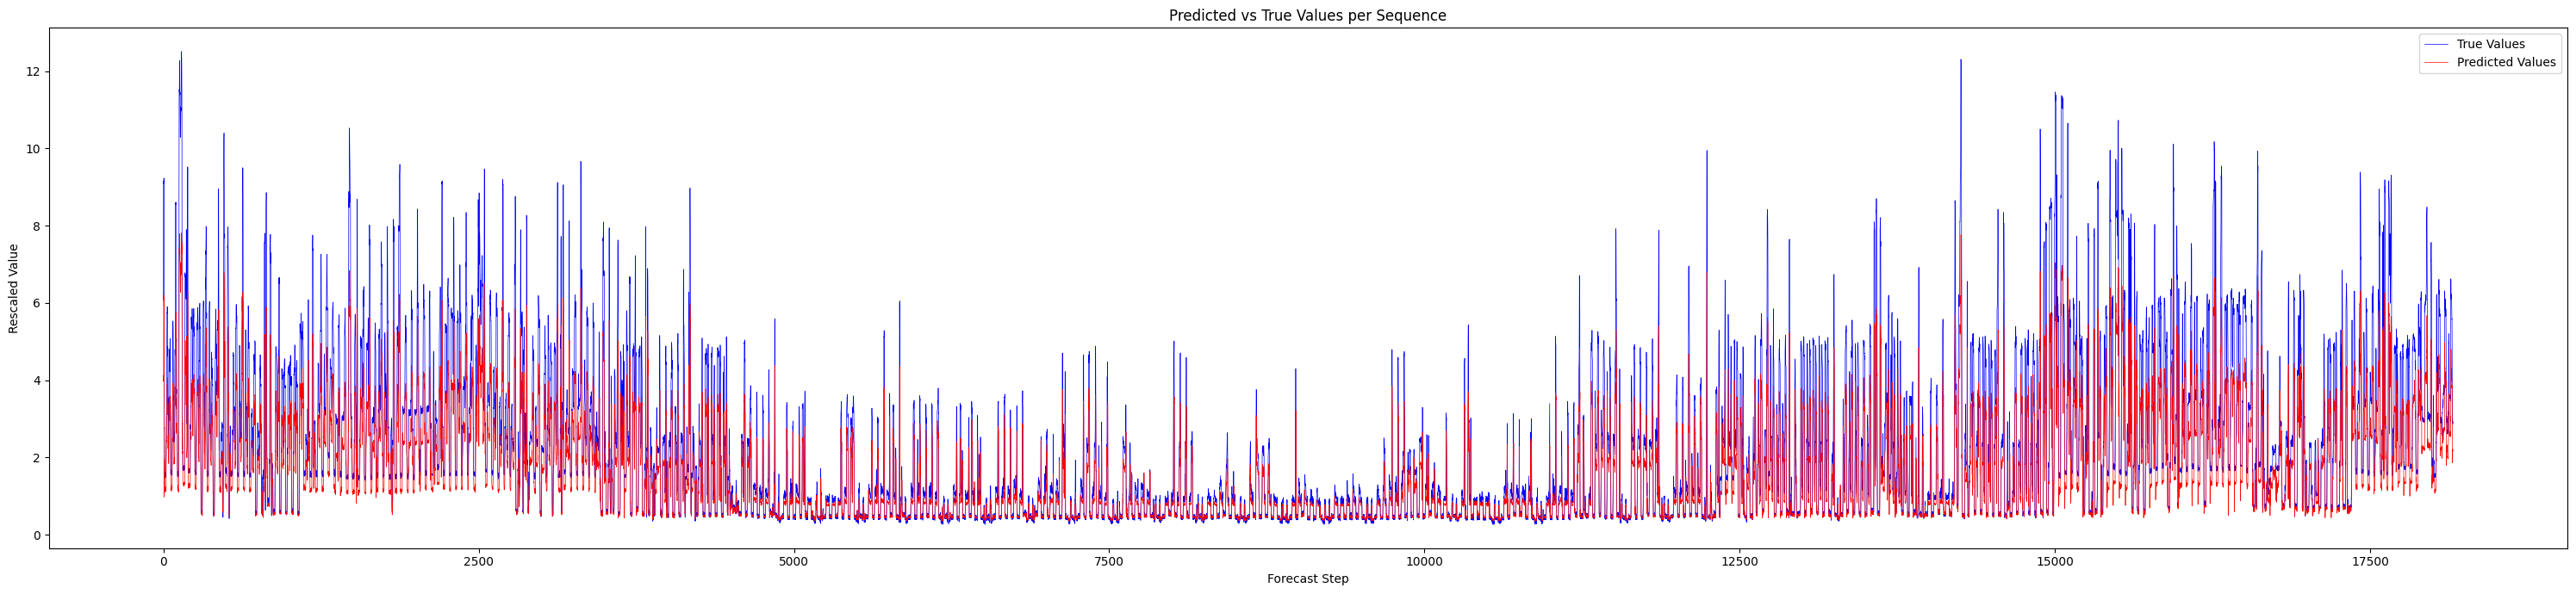


🔁 Training with lookback=2, horizon=2
Epoch 1/150


c:\Users\janav\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


273/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0548 - mae: 0.0548
Epoch 1: val_mae improved from inf to 0.02977, saving model to best_model_2_2.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0541 - mae: 0.0541 - val_loss: 0.0298 - val_mae: 0.0298 - learning_rate: 0.0010
Epoch 2/150
270/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0201 - mae: 0.0201
Epoch 2: val_mae improved from 0.02977 to 0.02493, saving model to best_model_2_2.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0200 - mae: 0.0200 - val_loss: 0.0249 - val_mae: 0.0249 - learning_rate: 0.0010
Epoch 3/150
281/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0182 - mae: 0.0182
Epoch 3: val_mae improved from 0.02493 to 0.02268, saving model to best_model_2_2.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0182 - mae: 0.0182 - val_loss: 0.0227 - val_mae: 0.0227 - learning_rate: 0.0010
Epoch 4/150
281/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0171 - mae: 0.0171
Epoch 4: val_mae did not improve from 0.02268
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0171 - mae: 0.0171 - val_loss: 0.0242 - val_mae: 0.0242 - learning_rate: 0.0010
Epoch 5/150
277/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0163 - mae: 0.0163
Epoch 5: val_mae did not improve from 0.02268
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0163 - mae: 0.0163 - val_loss: 0.0254 - val_mae: 0.0254 - learning_rate: 0.0010
Epoch 6/150
279/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0161 - mae: 0.0161
Epoch 6: val_mae improved from 0.02268 to 0.02267, saving model to best_model_2_2.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0161 - mae: 0.0161 - val_loss: 0.0227 - val_mae: 0.0227 - learning_rate: 0.0010
Epoch 7/150
283/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0159 - mae: 0.0159
Epoch 7: val_mae did not improve from 0.02267
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0159 - mae: 0.0159 - val_loss: 0.0239 - val_mae: 0.0239 - learning_rate: 0.0010
Epoch 8/150
278/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0157 - mae: 0.0157
Epoch 8: val_mae did not improve from 0.02267
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0157 - mae: 0.0157 - val_loss: 0.0259 - val_mae: 0.0259 - learning_rate: 0.0010
Epoch 9/150
276/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0153 - mae: 0.0153
Epoch 9: val_mae improved from 0.02267 to 0.02259, saving model to best_model_2_2.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0153 - mae: 0.0153 - val_loss: 0.0226 - val_mae: 0.0226 - learning_rate: 0.0010
Epoch 10/150
280/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0151 - mae: 0.0151
Epoch 10: val_mae improved from 0.02259 to 0.02180, saving model to best_model_2_2.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0151 - mae: 0.0151 - val_loss: 0.0218 - val_mae: 0.0218 - learning_rate: 0.0010
Epoch 11/150
272/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0149 - mae: 0.0149
Epoch 11: val_mae did not improve from 0.02180
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0149 - mae: 0.0149 - val_loss: 0.0244 - val_mae: 0.0244 - learning_rate: 0.0010
Epoch 12/150
277/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0143 - mae: 0.0143
Epoch 12: val_mae did not improve from 0.02180
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0143 - mae: 0.0143 - val_loss: 0.0265 - val_mae: 0.0265 - learning_rate: 0.0010
Epoch 13/150
278/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0144 - mae: 0.0144
Epoch 13: val_mae did not improve from 0.02180
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0144 - mae: 0.0144 - val_loss: 0.0254 - val_mae: 0.0254 - learning_rate: 0.0010
Epoch 14/150
280/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0144 - mae: 0.0144
Epo

568/568 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
📊 Evaluation Metrics:
MAE:  0.4223
RMSE: 0.8016
MAPE: 22.80%


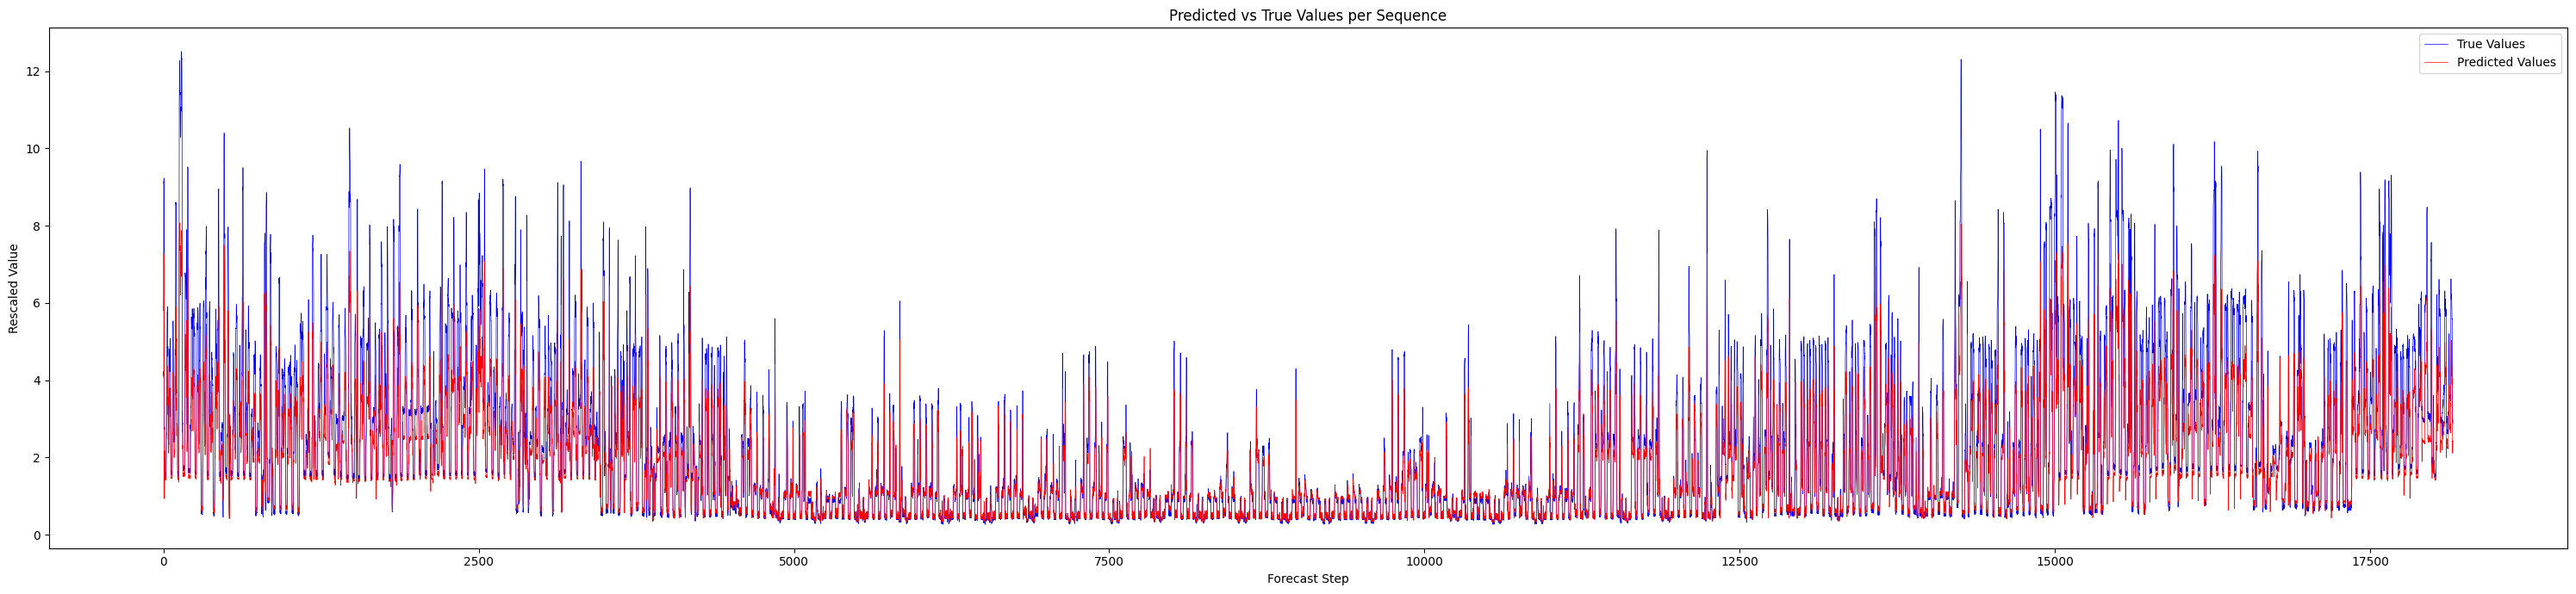


🔁 Training with lookback=2, horizon=6
Epoch 1/150


c:\Users\janav\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


283/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0580 - mae: 0.0580
Epoch 1: val_mae improved from inf to 0.03703, saving model to best_model_2_6.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0579 - mae: 0.0579 - val_loss: 0.0370 - val_mae: 0.0370 - learning_rate: 0.0010
Epoch 2/150
278/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0272 - mae: 0.0272
Epoch 2: val_mae improved from 0.03703 to 0.03631, saving model to best_model_2_6.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0272 - mae: 0.0272 - val_loss: 0.0363 - val_mae: 0.0363 - learning_rate: 0.0010
Epoch 3/150
278/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0253 - mae: 0.0253
Epoch 3: val_mae improved from 0.03631 to 0.03570, saving model to best_model_2_6.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0253 - mae: 0.0253 - val_loss: 0.0357 - val_mae: 0.0357 - learning_rate: 0.0010
Epoch 4/150
278/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0242 - mae: 0.0242
Epoch 4: val_mae did not improve from 0.03570
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0242 - mae: 0.0242 - val_loss: 0.0367 - val_mae: 0.0367 - learning_rate: 0.0010
Epoch 5/150
278/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0230 - mae: 0.0230
Epoch 5: val_mae improved from 0.03570 to 0.03525, saving model to best_model_2_6.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0230 - mae: 0.0230 - val_loss: 0.0353 - val_mae: 0.0353 - learning_rate: 0.0010
Epoch 6/150
279/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0225 - mae: 0.0225
Epoch 6: val_mae did not improve from 0.03525
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0225 - mae: 0.0225 - val_loss: 0.0363 - val_mae: 0.0363 - learning_rate: 0.0010
Epoch 7/150
279/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0219 - mae: 0.0219
Epoch 7: val_mae did not improve from 0.03525
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0219 - mae: 0.0219 - val_loss: 0.0361 - val_mae: 0.0361 - learning_rate: 0.0010
Epoch 8/150
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0216 - mae: 0.0216
Epoch 8: val_mae did not improve from 0.03525
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0216 - mae: 0.0216 - val_loss: 0.0370 - val_mae: 0.0370 - learning_rate: 0.0010
Epoch 9/150
271/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0215 - mae: 0.0215
Epoch 9: v

284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0205 - mae: 0.0205 - val_loss: 0.0347 - val_mae: 0.0347 - learning_rate: 0.0010
Epoch 13/150
278/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0207 - mae: 0.0207
Epoch 13: val_mae did not improve from 0.03469
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0207 - mae: 0.0207 - val_loss: 0.0383 - val_mae: 0.0383 - learning_rate: 0.0010
Epoch 14/150
282/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0204 - mae: 0.0204
Epoch 14: val_mae did not improve from 0.03469
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0204 - mae: 0.0204 - val_loss: 0.0367 - val_mae: 0.0367 - learning_rate: 0.0010
Epoch 15/150
283/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0203 - mae: 0.0203
Epoch 15: val_mae did not improve from 0.03469
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0203 - mae: 0.0203 - val_loss: 0.0392 - val_mae: 0.0392 - learning_rate: 0.0010
Epoch 16/150
276/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0199 - mae: 0.0199
Epo

568/568 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
📊 Evaluation Metrics:
MAE:  0.6753
RMSE: 1.1860
MAPE: 34.14%


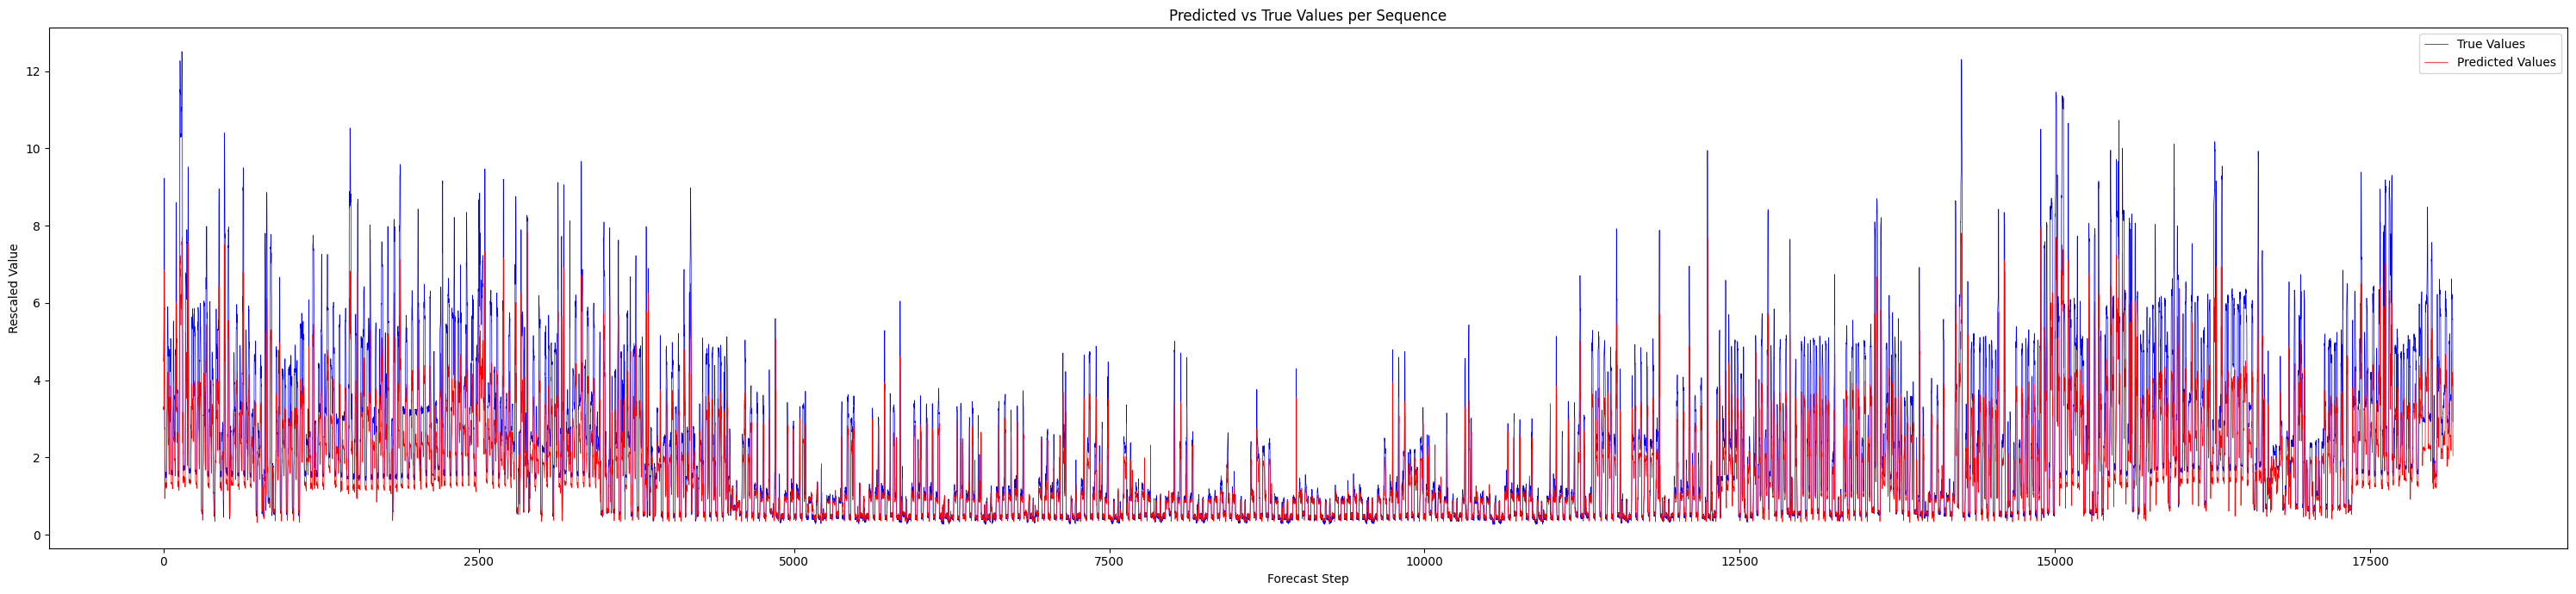


🔁 Training with lookback=6, horizon=1
Epoch 1/150


c:\Users\janav\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


279/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0506 - mae: 0.0506
Epoch 1: val_mae improved from inf to 0.02987, saving model to best_model_6_1.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0502 - mae: 0.0502 - val_loss: 0.0299 - val_mae: 0.0299 - learning_rate: 0.0010
Epoch 2/150
277/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0215 - mae: 0.0215
Epoch 2: val_mae improved from 0.02987 to 0.02417, saving model to best_model_6_1.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0214 - mae: 0.0214 - val_loss: 0.0242 - val_mae: 0.0242 - learning_rate: 0.0010
Epoch 3/150
275/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0184 - mae: 0.0184
Epoch 3: val_mae improved from 0.02417 to 0.02127, saving model to best_model_6_1.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0183 - mae: 0.0183 - val_loss: 0.0213 - val_mae: 0.0213 - learning_rate: 0.0010
Epoch 4/150
283/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0166 - mae: 0.0166
Epoch 4: val_mae did not improve from 0.02127
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0166 - mae: 0.0166 - val_loss: 0.0224 - val_mae: 0.0224 - learning_rate: 0.0010
Epoch 5/150
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0153 - mae: 0.0153
Epoch 5: val_mae did not improve from 0.02127
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0153 - mae: 0.0153 - val_loss: 0.0218 - val_mae: 0.0218 - learning_rate: 0.0010
Epoch 6/150
282/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0146 - mae: 0.0146
Epoch 6: val_mae did not improve from 0.02127
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0146 - mae: 0.0146 - val_loss: 0.0230 - val_mae: 0.0230 - learning_rate: 0.0010
Epoch 7/150
282/284 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0138 - mae: 0.0138
Epoch 7: v

dict_keys(['loss', 'mae', 'val_loss', 'val_mae', 'learning_rate'])
✅ Loaded saved model from: best_model_6_1.h5
568/568 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
📊 Evaluation Metrics:
MAE:  0.4217
RMSE: 0.7609
MAPE: 23.92%


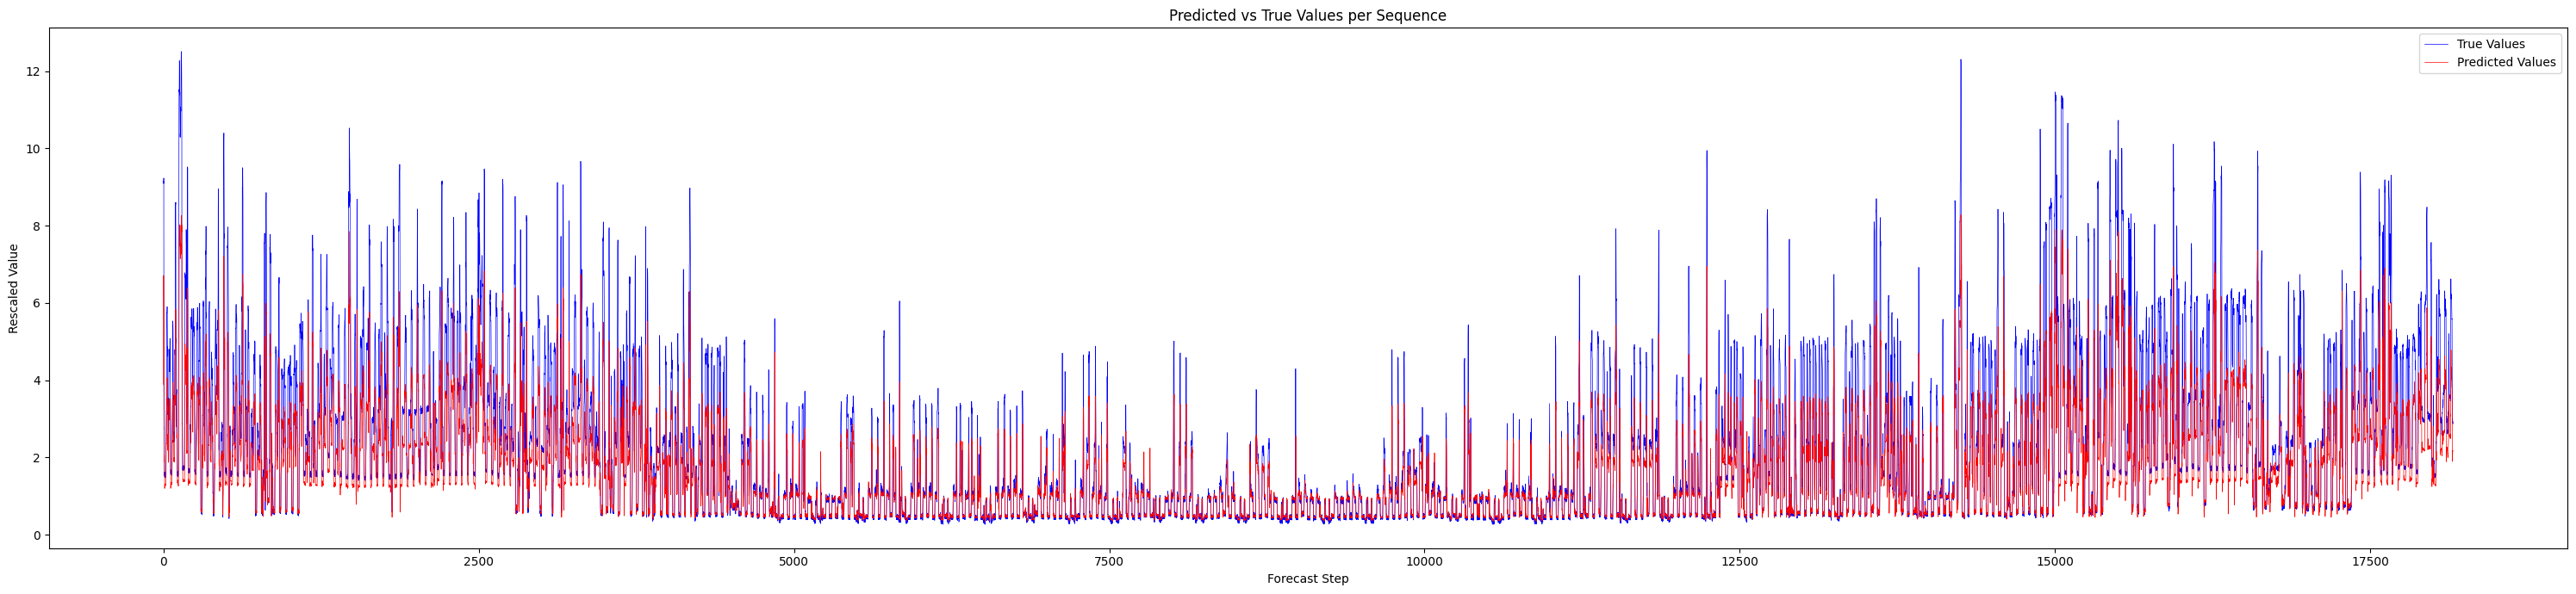


🔁 Training with lookback=6, horizon=2
Epoch 1/150


c:\Users\janav\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0533 - mae: 0.0533
Epoch 1: val_mae improved from inf to 0.03142, saving model to best_model_6_2.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0532 - mae: 0.0532 - val_loss: 0.0314 - val_mae: 0.0314 - learning_rate: 0.0010
Epoch 2/150
276/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0235 - mae: 0.0235
Epoch 2: val_mae improved from 0.03142 to 0.02875, saving model to best_model_6_2.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0235 - mae: 0.0235 - val_loss: 0.0287 - val_mae: 0.0287 - learning_rate: 0.0010
Epoch 3/150
277/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0207 - mae: 0.0207
Epoch 3: val_mae improved from 0.02875 to 0.02698, saving model to best_model_6_2.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0207 - mae: 0.0207 - val_loss: 0.0270 - val_mae: 0.0270 - learning_rate: 0.0010
Epoch 4/150
280/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0183 - mae: 0.0183
Epoch 4: val_mae improved from 0.02698 to 0.02686, saving model to best_model_6_2.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0183 - mae: 0.0183 - val_loss: 0.0269 - val_mae: 0.0269 - learning_rate: 0.0010
Epoch 5/150
281/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0174 - mae: 0.0174
Epoch 5: val_mae improved from 0.02686 to 0.02557, saving model to best_model_6_2.h5


284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0174 - mae: 0.0174 - val_loss: 0.0256 - val_mae: 0.0256 - learning_rate: 0.0010
Epoch 6/150
281/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0166 - mae: 0.0166
Epoch 6: val_mae did not improve from 0.02557
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0165 - mae: 0.0165 - val_loss: 0.0272 - val_mae: 0.0272 - learning_rate: 0.0010
Epoch 7/150
281/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0159 - mae: 0.0159
Epoch 7: val_mae did not improve from 0.02557
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0159 - mae: 0.0159 - val_loss: 0.0289 - val_mae: 0.0289 - learning_rate: 0.0010
Epoch 8/150
278/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0156 - mae: 0.0156
Epoch 8: val_mae did not improve from 0.02557
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0156 - mae: 0.0156 - val_loss: 0.0297 - val_mae: 0.0297 - learning_rate: 0.0010
Epoch 9/150
280/284 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0152 - mae: 0.0152
Epoch 9: v

KeyboardInterrupt: 

In [13]:
import pandas as pd
from tensorflow.keras.models import load_model
import os 

results = []

timesteps_list = [2, 6, 12]
horizon_list = [1, 2, 6]

for input_window in timesteps_list:
    for forecast_horizon in horizon_list:
        print(f"\n🔁 Training with lookback={input_window}, horizon={forecast_horizon}")
        try:
            # Prepare sequences
            X_train, y_train, X_val, y_val, X_test, y_test, scaler = prepare_sequences(
                df, input_window=input_window, forecast_horizon=forecast_horizon,
                val_ratio=0.1, test_ratio=0.3
            )
            # Build model
            model = build_cnn_lstm_model(
                input_shape=(X_train.shape[1], X_train.shape[2]),
                output_size=y_train.shape[1]
            )

            model_path = f"best_model_{input_window}_{forecast_horizon}.h5"

            # Train and save the best model
            model, history = train_model(model, X_train, y_train, X_val, y_val, model_path=model_path)

            # Try to load the best saved model; fallback to last epoch model if not saved
            if os.path.exists(model_path):
                print(f"✅ Loaded saved model from: {model_path}")
                best_model = load_model(model_path)
            else:
                print(f"⚠️ No saved model found for {input_window}-{forecast_horizon}. Using model from last epoch.")
                best_model = model

            # Evaluate loaded model
            metrics = evaluate_forecasting_model(best_model, X_test, y_test, scaler)

            # Save results
            results.append({
                "lookback": input_window,
                "lookahead": forecast_horizon,
                "mae": metrics["mae"],
                "rmse": metrics["rmse"],
                "mape": metrics["mape"]
            })

            plot(model, X_test, y_test, scaler)
        
        except Exception as e:
            print(f"❌ Failed for lookback={input_window}, horizon={forecast_horizon}: {e}")
            results.append({
                "lookback": input_window,
                "lookahead": forecast_horizon,
                "mae": None,
                "rmse": None,
                "mape": None
            })

# Convert to DataFrame
results_df = pd.DataFrame(results)
print("\n✅ Final Results:")
print(results_df)


In [65]:
len(df.columns)

58

In [9]:
results_df.to_csv("results.csv", index=False)

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


def parse_model_name(name):
    parts = name.split("_")
    return int(parts[-2]), int(parts[-1])  # input_window, forecast_horizon

import numpy as np

def horizon_rolling_forecast(model, initial_input, X_test, forecast_horizon, input_window, scaler):
    preds = []
    current_input = initial_input.copy()
    total_chunks = len(X_test) // forecast_horizon

    for i in range(total_chunks):
        print(f"🔮 Forecast chunk {i + 1}/{total_chunks}", end='\r', flush=True)

        # Predict next horizon values
        pred = model.predict(current_input, verbose=0)[0]  # shape: (horizon,)
        preds.extend(pred.tolist())

        # Get real input features for next horizon
        x_next_chunk = X_test[i * forecast_horizon: (i + 1) * forecast_horizon]

        # If 3D, take last timestep per horizon step
        if x_next_chunk.ndim == 3:
            x_next_chunk = x_next_chunk[:, -1, :]  # shape: (horizon, features)

        # Exclude target column (assumed to be first column)
        x_next_features = x_next_chunk[:, 1:]  # shape: (horizon, feature_dim - 1)

        # Combine predicted target + real features
        pred_array = np.array(pred).reshape(forecast_horizon, 1)  # shape: (horizon, 1)
        combined = np.concatenate([pred_array, x_next_features], axis=1)  # shape: (horizon, feature_dim)

        # Update current input window
        current_input = np.concatenate([
            current_input.reshape(-1, current_input.shape[-1]),  # shape: (input_window, feature_dim)
            combined
        ], axis=0)

        # Trim to keep only last `input_window` steps and reshape to model input shape
        current_input = current_input[-input_window:].reshape(1, input_window, -1)

    preds = np.array(preds).reshape(-1, 1)
    return scaler.inverse_transform(preds).flatten()




def plot_iterative(true_vals, pred_vals, label="Model"):
    plt.figure(figsize=(30, 7))
    plt.plot(true_vals, label="True Values", color="blue", linewidth=0.5)
    plt.plot(pred_vals, label=f"Predicted by {label}", color="red", linewidth=0.5)
    plt.title(f"Iterative Forecast: {label}")
    plt.xlabel("Timestep")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()



In [91]:
os.listdir(model_dir)

['best_model_12_1.h5',
 'best_model_12_2.h5',
 'best_model_12_6.h5',
 'best_model_2_1.h5',
 'best_model_2_2.h5',
 'best_model_2_6.h5',
 'best_model_6_1.h5',
 'best_model_6_2.h5',
 'best_model_6_6.h5']

✅ Loaded model: best_model_12_1 with window=12, horizon=1
🔁 Running iterative forecast for best_model_12_1 with input_window=12, forecast_horizon=1


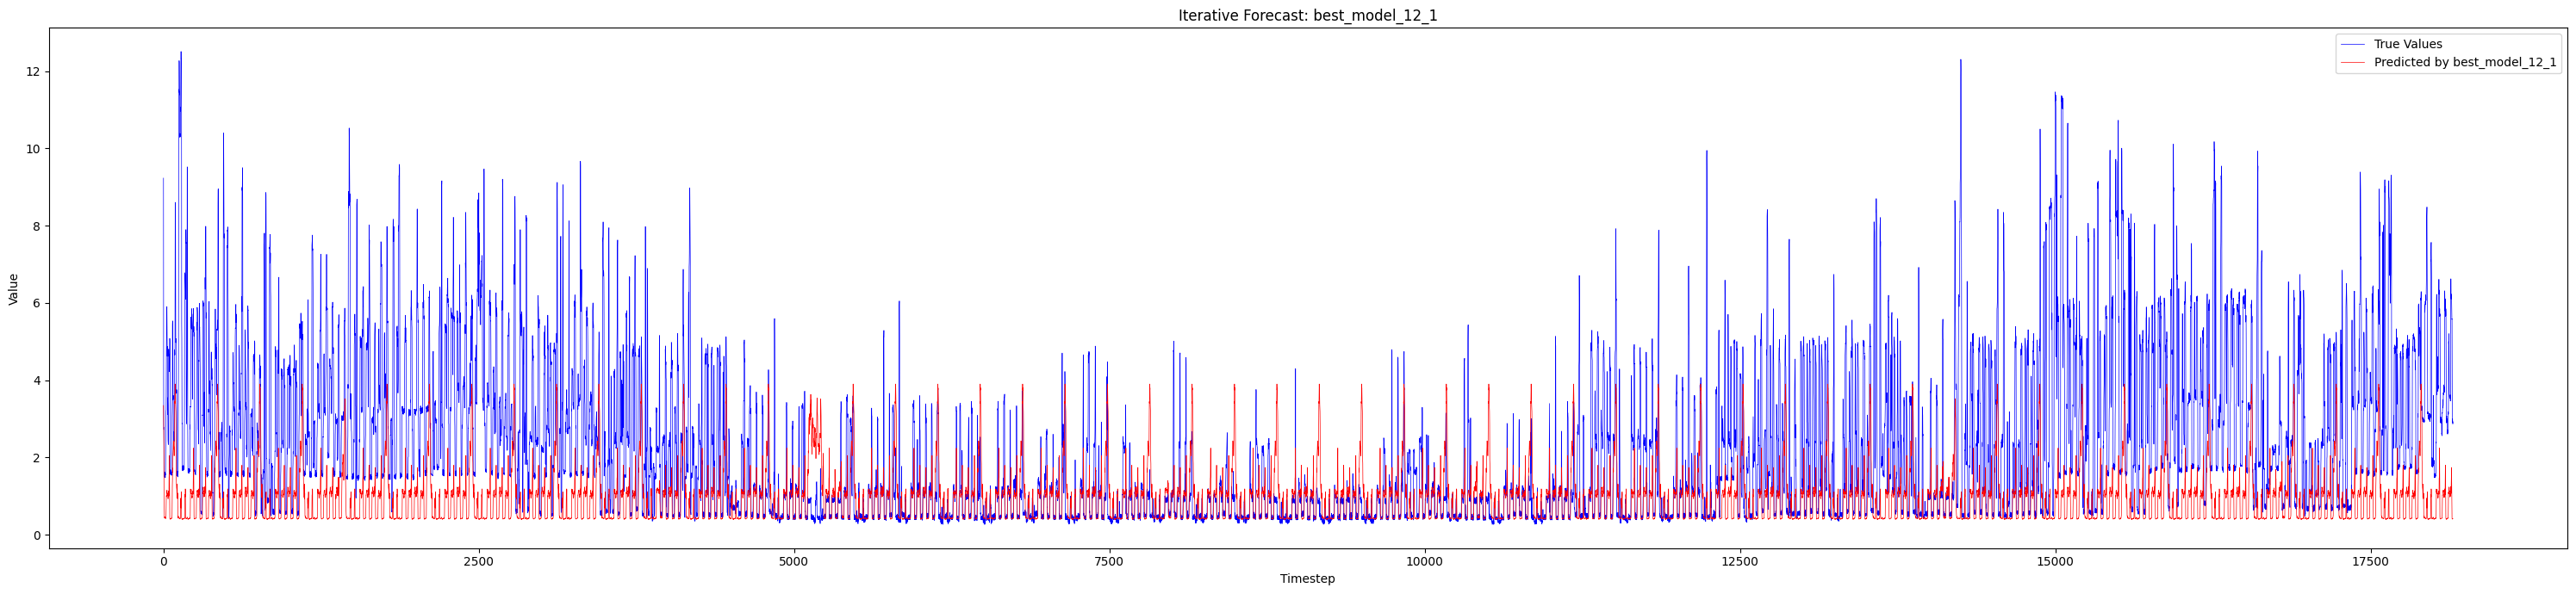

📊 Evaluation Metrics:
MAE:  1.4638
RMSE: 2.3108
MAPE: 56.96%
✅ Loaded model: best_model_12_2 with window=12, horizon=2
🔁 Running iterative forecast for best_model_12_2 with input_window=12, forecast_horizon=2


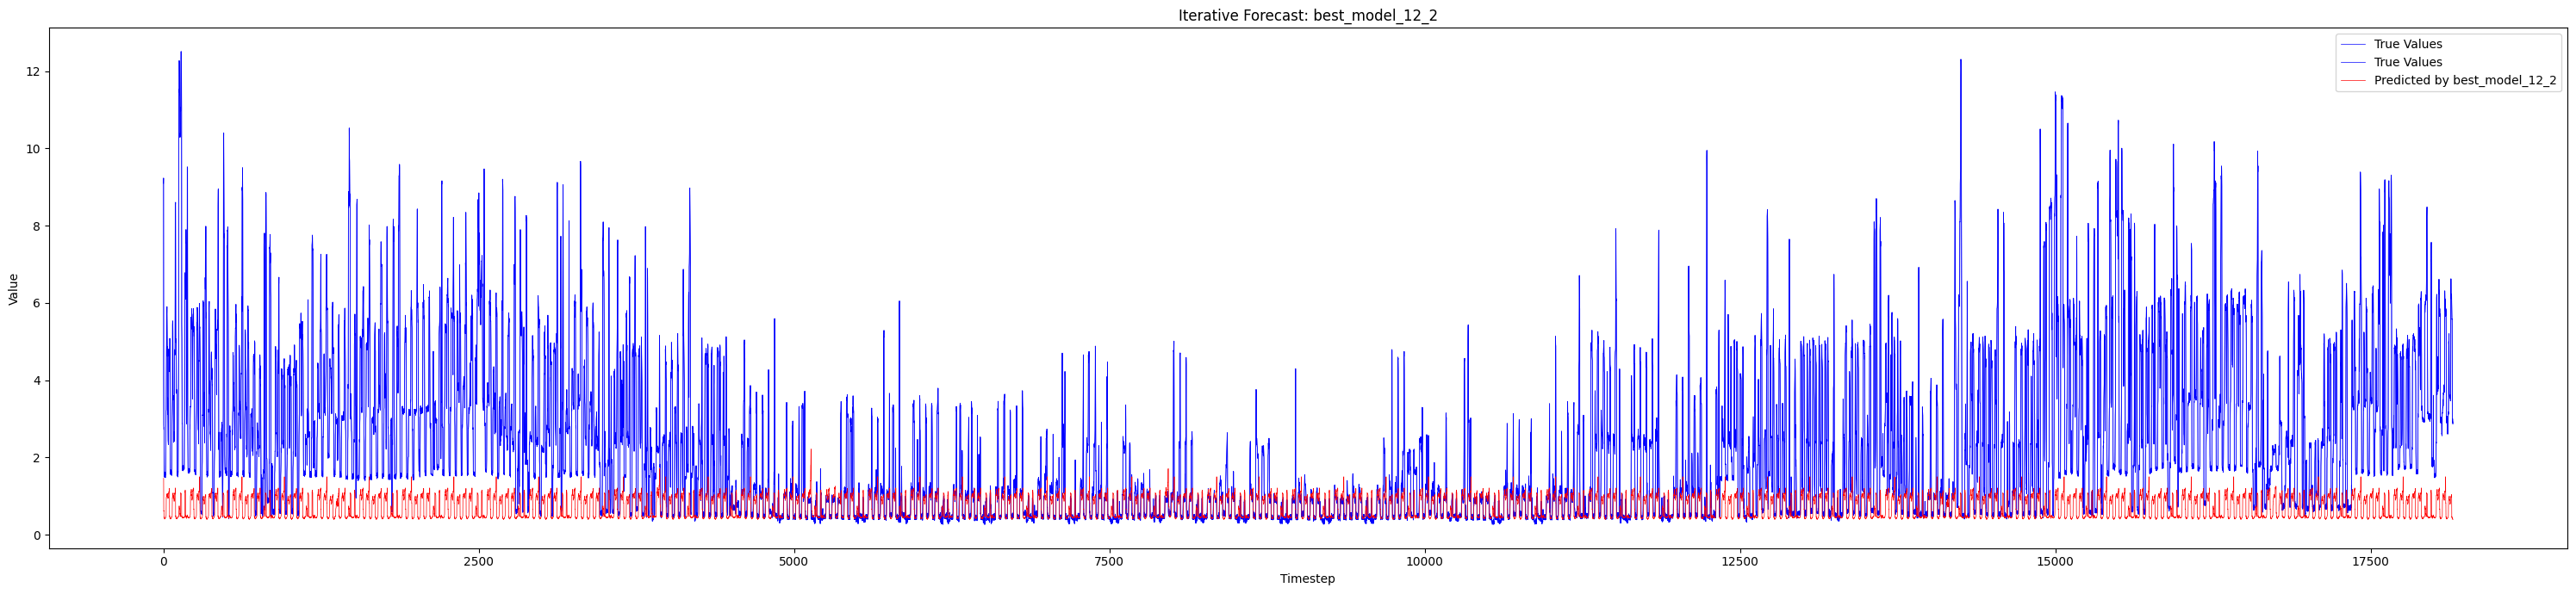

📊 Evaluation Metrics:
MAE:  1.5438
RMSE: 2.3835
MAPE: 63.06%
✅ Loaded model: best_model_12_6 with window=12, horizon=6
🔁 Running iterative forecast for best_model_12_6 with input_window=12, forecast_horizon=6


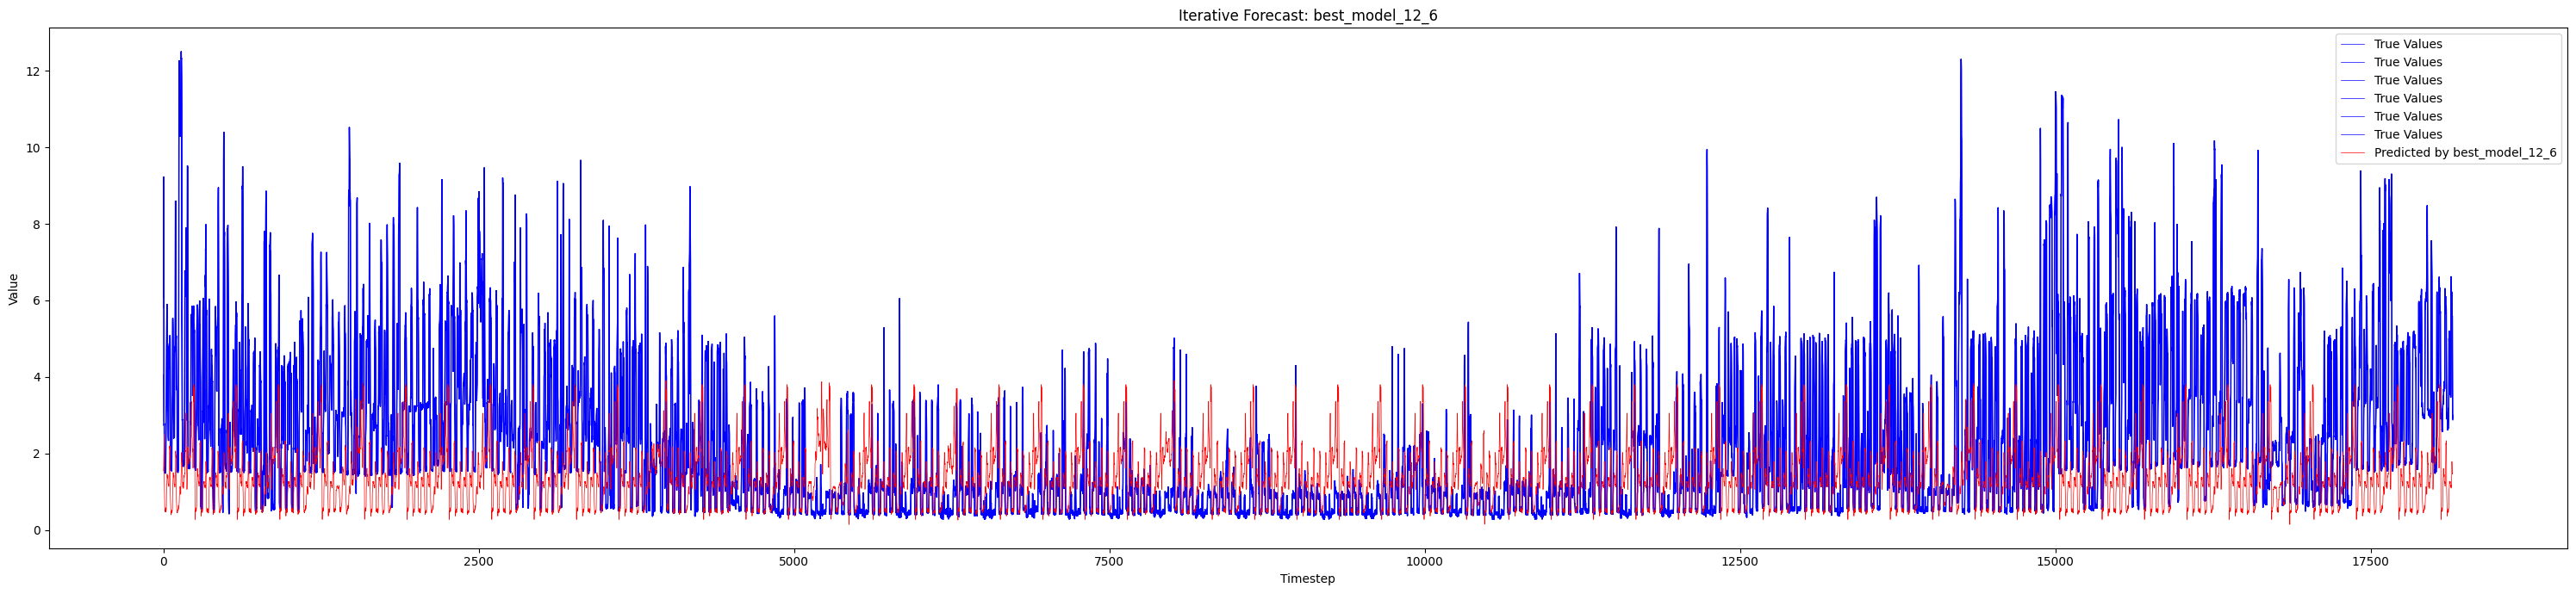

📊 Evaluation Metrics:
MAE:  2.3538
RMSE: 3.1051
MAPE: 61.88%
✅ Loaded model: best_model_2_1 with window=2, horizon=1
🔁 Running iterative forecast for best_model_2_1 with input_window=2, forecast_horizon=1


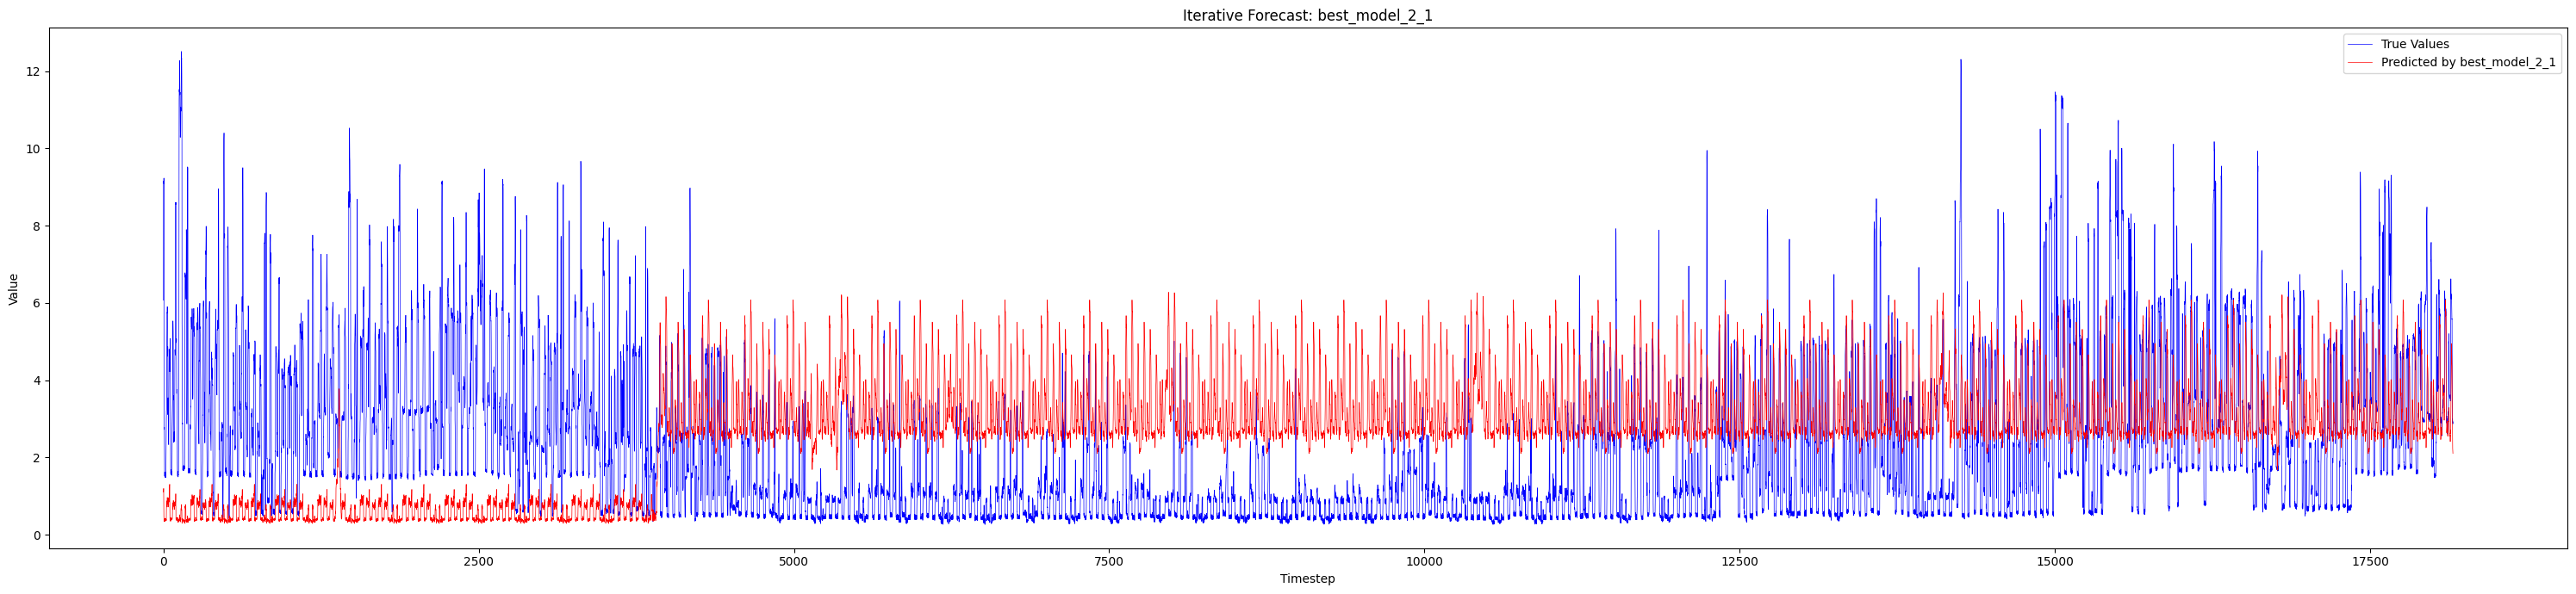

📊 Evaluation Metrics:
MAE:  2.1837
RMSE: 2.6028
MAPE: 232.35%
✅ Loaded model: best_model_2_2 with window=2, horizon=2
🔁 Running iterative forecast for best_model_2_2 with input_window=2, forecast_horizon=2


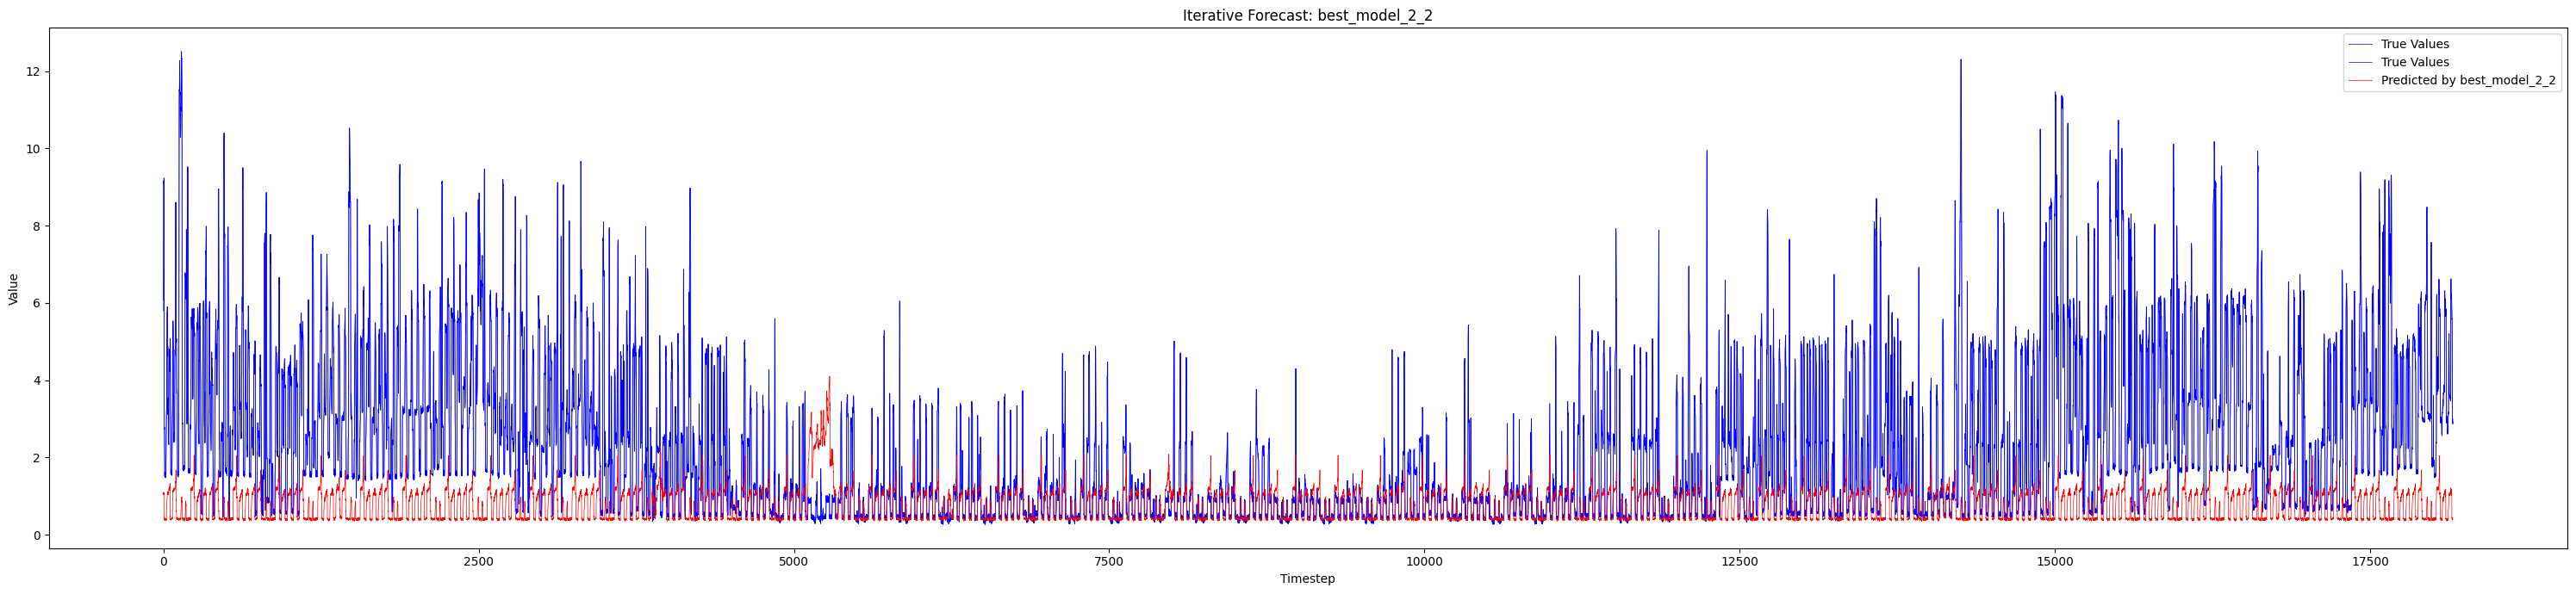

📊 Evaluation Metrics:
MAE:  1.5437
RMSE: 2.3724
MAPE: 67.14%
✅ Loaded model: best_model_2_6 with window=2, horizon=6
🔁 Running iterative forecast for best_model_2_6 with input_window=2, forecast_horizon=6


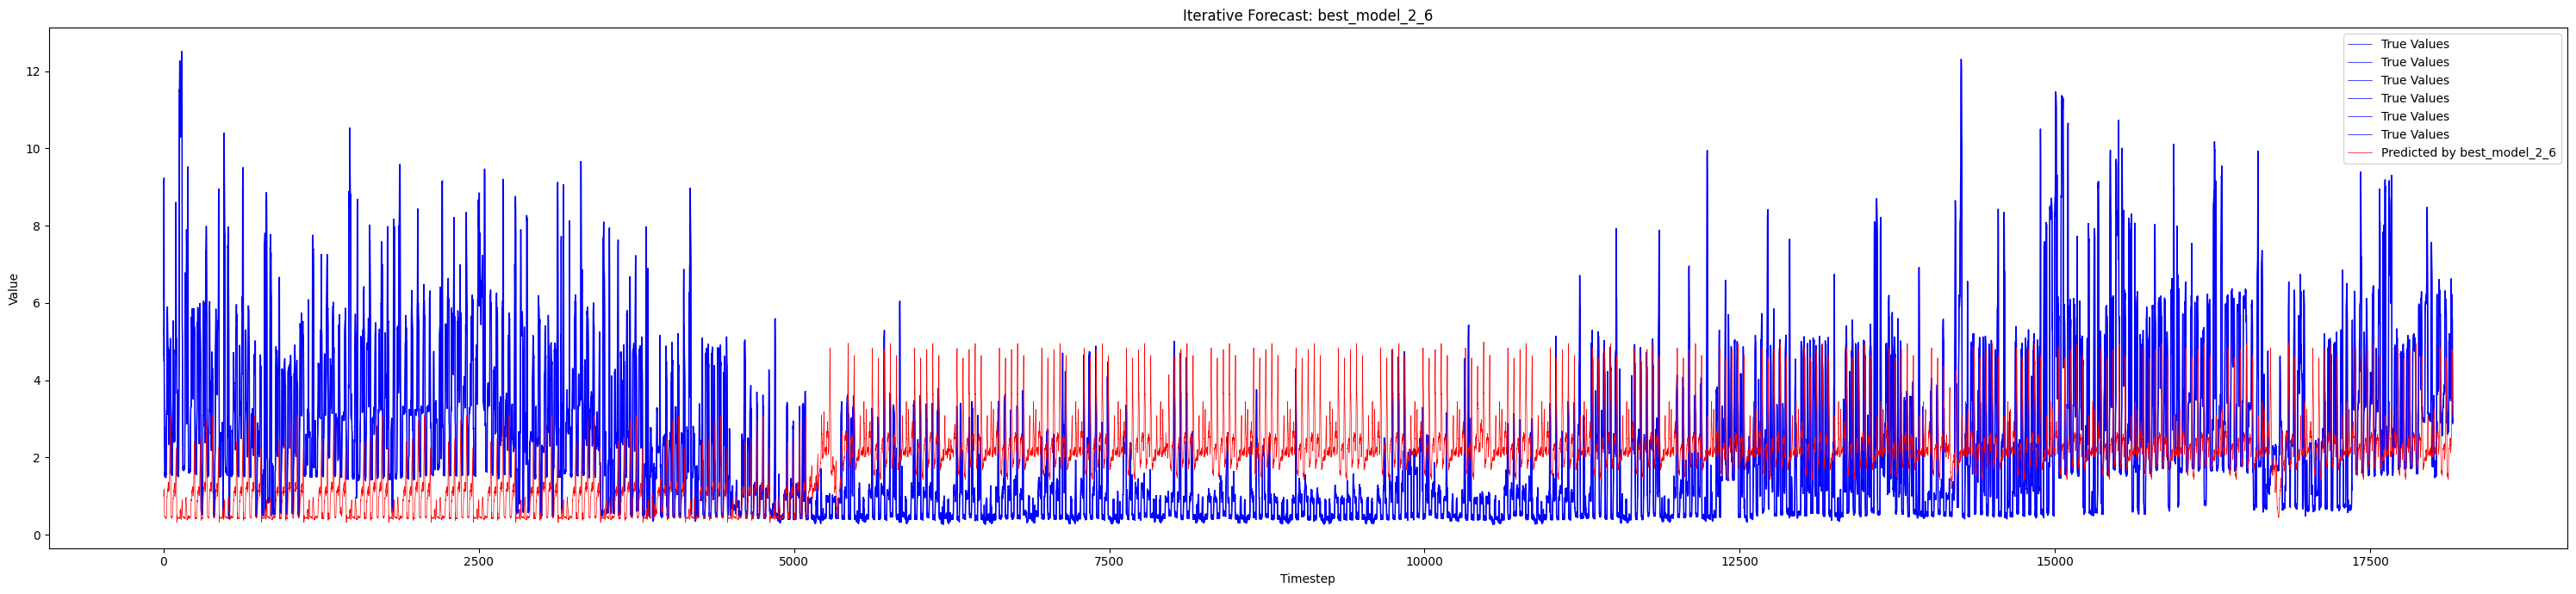

📊 Evaluation Metrics:
MAE:  2.0401
RMSE: 2.7800
MAPE: 60.17%
✅ Loaded model: best_model_6_1 with window=6, horizon=1
🔁 Running iterative forecast for best_model_6_1 with input_window=6, forecast_horizon=1


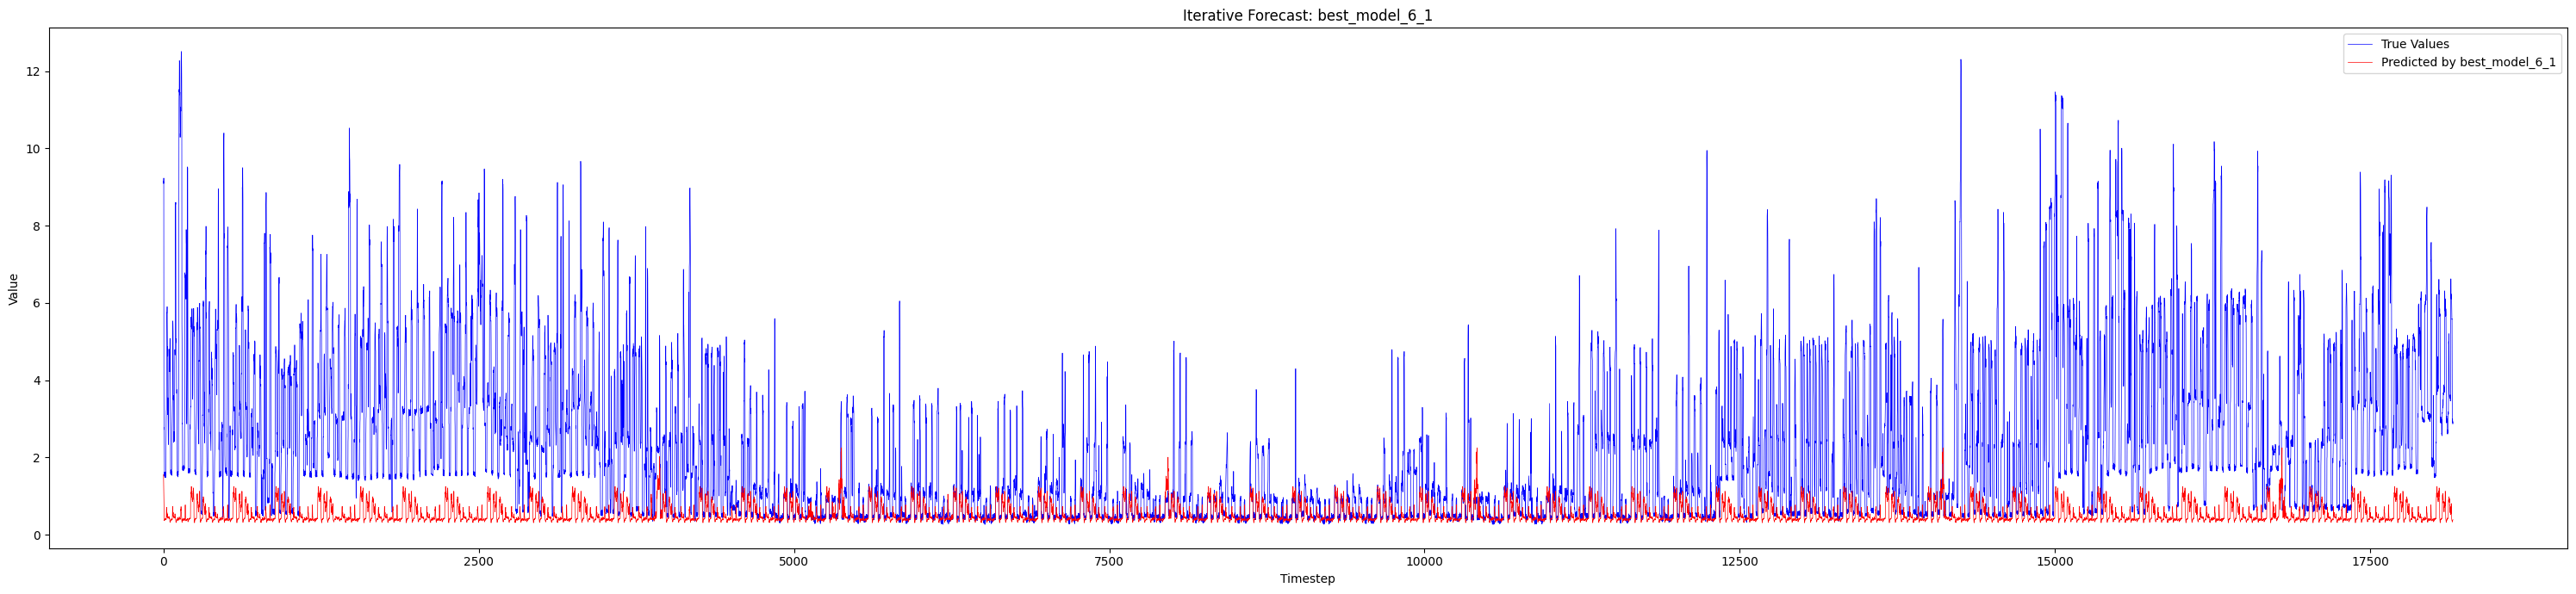

📊 Evaluation Metrics:
MAE:  1.6583
RMSE: 2.5697
MAPE: 54.75%
✅ Loaded model: best_model_6_2 with window=6, horizon=2
🔁 Running iterative forecast for best_model_6_2 with input_window=6, forecast_horizon=2


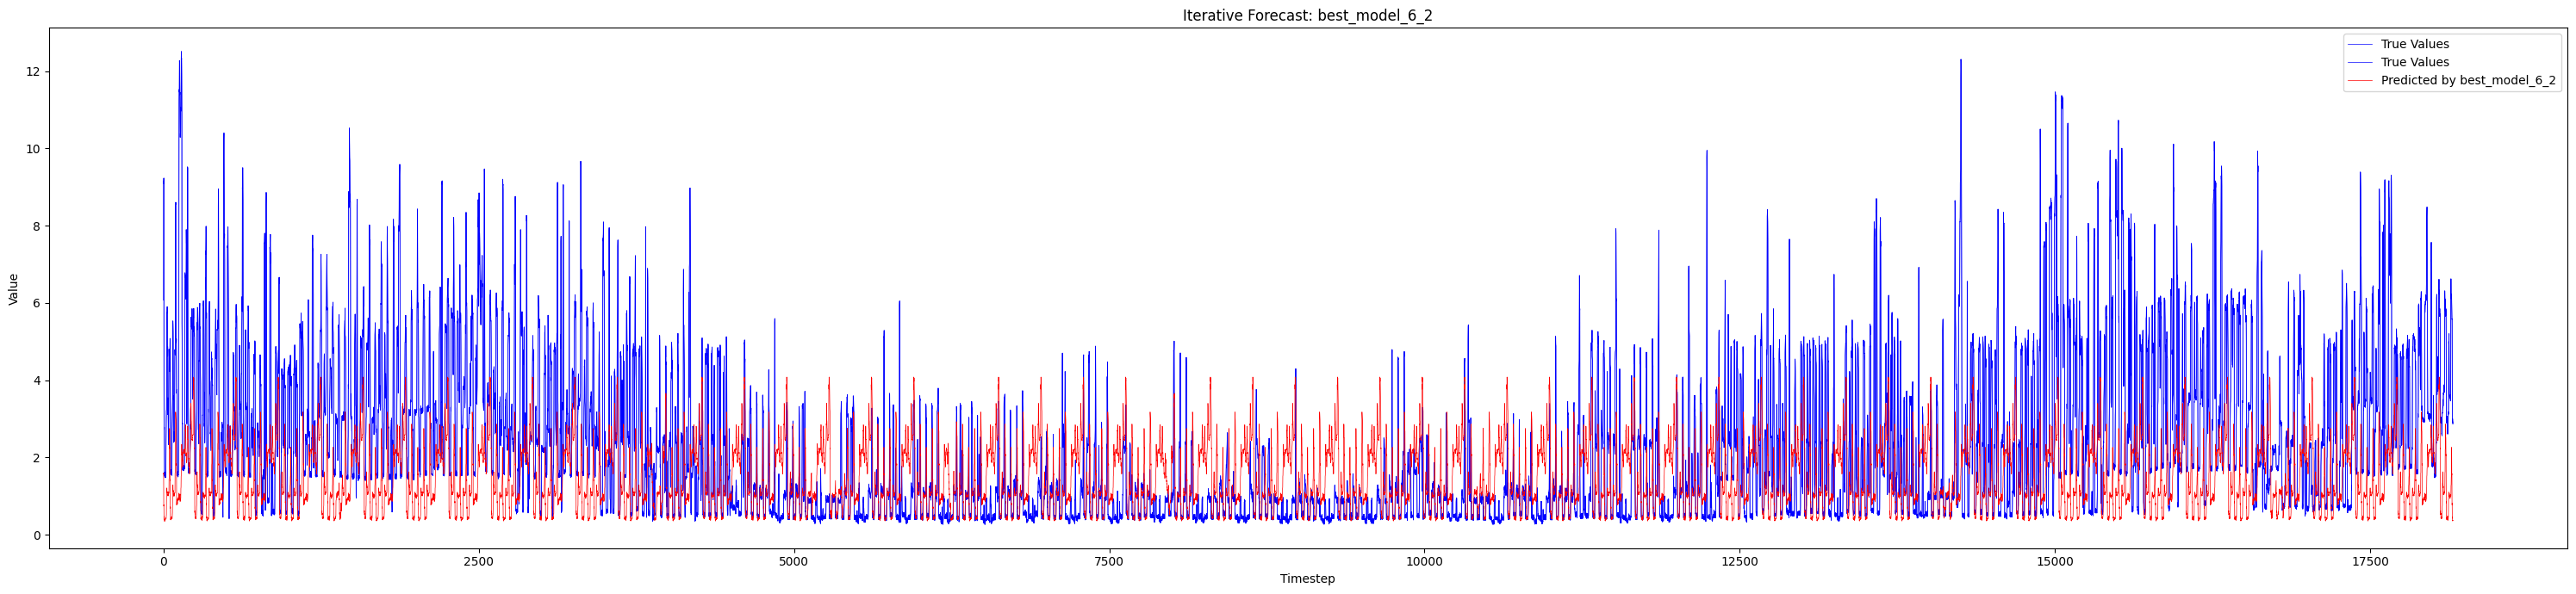

📊 Evaluation Metrics:
MAE:  1.4969
RMSE: 2.1439
MAPE: 104.51%
✅ Loaded model: best_model_6_6 with window=6, horizon=6
🔁 Running iterative forecast for best_model_6_6 with input_window=6, forecast_horizon=6


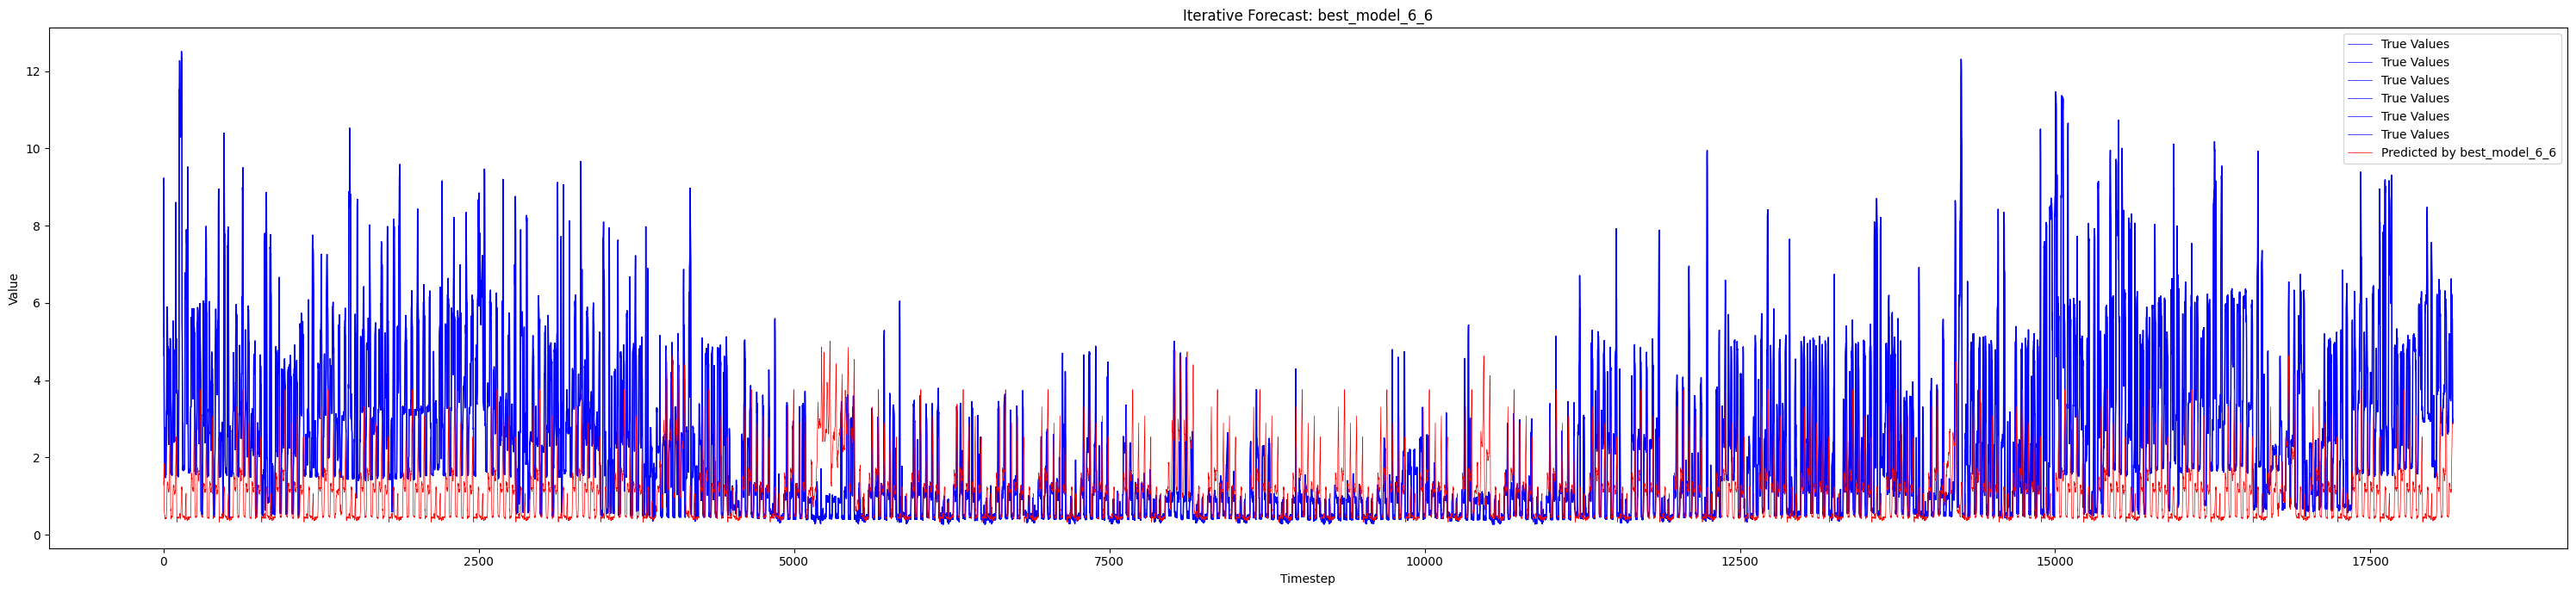

📊 Evaluation Metrics:
MAE:  2.5969
RMSE: 3.3108
MAPE: 69.91%


In [102]:
model_dir = 'models'
for fname in os.listdir(model_dir):
#for fname in ['best_model_12_6.h5']:
    if not fname.endswith('.h5'):
        continue

    model_path = os.path.join(model_dir, fname)
    model_name = os.path.splitext(fname)[0]
    
    try:
        input_window, forecast_horizon = parse_model_name(model_name)
        model = tf.keras.models.load_model(model_path)
        print(f"✅ Loaded model: {model_name} with window={input_window}, horizon={forecast_horizon}")
    except Exception as e:
        print(f"⚠️ Failed to load {fname}: {e}")
        continue

    # Prepare data
    X_train, y_train, X_val, y_val, X_test, y_test, scaler = prepare_sequences(
        df, input_window=input_window, forecast_horizon=forecast_horizon,
        val_ratio=0.1, test_ratio=0.3
    )

    # Use last training input to roll forward
    initial_input = X_train[-1:].copy()  # shape: [1, window, 1]
    total_steps = len(X_test)

    print(f"🔁 Running iterative forecast for {model_name} with input_window={input_window}, forecast_horizon={forecast_horizon}")

    true_rescaled = scaler.inverse_transform(y_test[:, :forecast_horizon])
    preds_rescaled = horizon_rolling_forecast(
        model=model,
        initial_input=initial_input,
        X_test=X_test,
        forecast_horizon=forecast_horizon,
        input_window=input_window,
        scaler=scaler
    )

    plot_iterative(true_rescaled, preds_rescaled, model_name)

    # Flatten y_true from shape (n, horizon) -> (n * horizon,)
    true_flat = true_rescaled.reshape(-1)[:len(preds_rescaled)]
    preds_flat = preds_rescaled.reshape(-1)

    # Evaluation
    mae = mean_absolute_error(true_flat, preds_flat)
    rmse = np.sqrt(mean_squared_error(true_flat, preds_flat))
    mape = np.mean(np.abs((true_flat - preds_flat) / (true_flat + 1e-8))) * 100

    print(f"📊 Evaluation Metrics:")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")

    